In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

from aparent.data.aparent_data_native_pairs import load_data

from scipy.stats import pearsonr

import sklearn.linear_model as sklinear
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr


Using TensorFlow backend.


In [2]:
#Load APADB data
file_path = '../../data/prepared_data/apa_leslie_apadb_pair_data/'
apadb_df = isoio.load(file_path + 'apa_leslie_apadb_pair_data')['df_pair']

#Filter on minimum pairwise read count
apadb_min_pair_count = 1000

apadb_keep_index = np.nonzero(np.ravel(apadb_df['apadb_pair_count_pooled'].values) >= apadb_min_pair_count)[0]
apadb_df = apadb_df.iloc[apadb_keep_index]

#Take only UTR3 APA events
apadb_df = apadb_df.query("(site_type_prox == 'UTR3' or site_type_prox == 'Extension') and (site_type_dist == 'UTR3' or site_type_dist == 'Extension')").copy()

#Take only events without miRNA losses
apadb_df = apadb_df.query("mirna_prox == mirna_dist").copy()

#Shuffle APADB dataframe
shuffle_index = np.arange(len(apadb_df))
np.random.shuffle(shuffle_index)

apadb_df = apadb_df.iloc[shuffle_index].copy().reset_index(drop=True)

print('APADB size = ' + str(len(apadb_df)))

apadb_index = np.arange(len(apadb_df), dtype=np.int)


APADB size = 2276


In [3]:
#Calculate relative APADB cut start and end positions within each sequence
def get_start_pos_prox(row) :
    if row['strand'] == '+' :
        return row['cut_start_prox'] - row['pas_pos_prox'] + 70
    else :
        return row['pas_pos_prox'] - row['cut_end_prox'] + 76

def get_end_pos_prox(row) :
    if row['strand'] == '+' :
        return row['cut_end_prox'] - row['pas_pos_prox'] + 70
    else :
        return row['pas_pos_prox'] - row['cut_start_prox'] + 76

def get_start_pos_dist(row) :
    if row['strand'] == '+' :
        return row['cut_start_dist'] - row['pas_pos_dist'] + 70
    else :
        return row['pas_pos_dist'] - row['cut_end_dist'] + 76

def get_end_pos_dist(row) :
    if row['strand'] == '+' :
        return row['cut_end_dist'] - row['pas_pos_dist'] + 70
    else :
        return row['pas_pos_dist'] - row['cut_start_dist'] + 76

apadb_df['rel_start_prox'] = apadb_df.apply(get_start_pos_prox, axis=1)
apadb_df['rel_end_prox'] = apadb_df.apply(get_end_pos_prox, axis=1)

apadb_df['rel_start_dist'] = apadb_df.apply(get_start_pos_dist, axis=1)
apadb_df['rel_end_dist'] = apadb_df.apply(get_end_pos_dist, axis=1)

In [4]:
#Create data generators for the train and test set

apadb_gen = iso.DataGenerator(
    apadb_index,
    {'df' : apadb_df},
    batch_size=len(apadb_index),
    inputs = [
        {
            'id' : 'seq_prox',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : iso.SequenceExtractor('wide_seq_ext_prox', start_pos=105, end_pos=105 + 205),
            'encoder' : iso.OneHotEncoder(seq_length=205),
            'dim' : (205, 4, 1),
            'sparsify' : False
        },
        {
            'id' : 'seq_dist',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : iso.SequenceExtractor('wide_seq_ext_dist', start_pos=105, end_pos=105 + 205),
            'encoder' : iso.OneHotEncoder(seq_length=205),
            'dim' : (205, 4, 1),
            'sparsify' : False
        },
        {
            'id' : 'start_prox',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: row['rel_start_prox'],
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'end_prox',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: row['rel_end_prox'],
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'start_dist',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: row['rel_start_dist'],
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'end_dist',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: row['rel_end_dist'],
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'site_distance',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: np.log(np.abs(row['cut_start_dist'] - row['cut_start_prox'])),
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'fake_lib',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: np.zeros(13),
            'transformer' : None,
            'dim' : (13,),
            'sparsify' : False
        },
        {
            'id' : 'fake_distal_pas',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: 1,
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'prox_count',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: row['apadb_count_pooled_prox'],
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'total_count',
            'source' : 'df',
            'source_type' : 'dataframe',
            'extractor' : lambda row, index: row['apadb_pair_count_pooled'],
            'transformer' : None,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

In [6]:
#Load APARENT model

save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = 'aparent_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)

aparent_model = load_model(model_path)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
#Use APARENT to predict non-normalized proximal/distal isoform scores

seq_prox = apadb_gen[0][0][0] #Batch 0 -> Inputs -> Proximal Sequence
seq_dist = apadb_gen[0][0][1] #Batch 0 -> Inputs -> Distal Sequence

#Generate fake model inputs for library biases (irrelevant for APADB)
fake_lib = np.zeros((seq_prox.shape[0], 13))
fake_distal_pas = np.ones((seq_prox.shape[0], 1))

_, cut_pred_prox = aparent_model.predict(x=[seq_prox, fake_lib, fake_distal_pas])
_, cut_pred_dist = aparent_model.predict(x=[seq_dist, fake_lib, fake_distal_pas])


In [8]:
#Calculate log odds isoform scores
start_prox, end_prox = apadb_gen[0][0][2], apadb_gen[0][0][3]
start_dist, end_dist = apadb_gen[0][0][4], apadb_gen[0][0][5]

iso_pred_prox = np.array([np.sum(cut_pred_prox[i, int(start_prox[i]): int(end_prox[i])]) for i in range(seq_prox.shape[0])])
iso_pred_dist = np.array([np.sum(cut_pred_dist[i, int(start_dist[i]): int(end_dist[i])]) for i in range(seq_dist.shape[0])])

prox_score = np.log(iso_pred_prox / (1.0 - iso_pred_prox))
dist_score = np.log(iso_pred_dist / (1.0 - iso_pred_dist))


In [9]:
#Create APADB regression features: prox_score, dist_score & site_distance
site_distance = apadb_gen[0][0][6]

X = np.zeros((seq_prox.shape[0], 3))
X[:, 0] = prox_score[:]
X[:, 1] = dist_score[:]
X[:, 2] = site_distance[:, 0]

#Create output regression target: proximal isoform log odds
prox_count = apadb_gen[0][1][0][:, 0]
total_count = apadb_gen[0][1][1][:, 0]

#Optional Laplace smoothing with pseudo counts
pseudo_count = 0.0

iso_true = (prox_count + pseudo_count) / (total_count + 2 * pseudo_count)
logodds_true = np.log(iso_true / (1.0 - iso_true))

APADB log isoform prediction R^2 (Cross-Val) = 0.7332073876638516
Accuracy = 0.9072934973637962


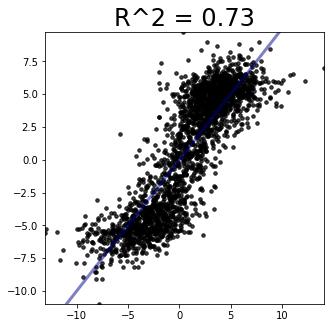

In [10]:
#Run linear regression cross-validation on APADB features, extract regression weights

def fit_loocv_model(X, y, l2_lambda=None) :
    lr = sklinear.LinearRegression()
    if l2_lambda is not None :
        lr = sklinear.Ridge(alpha=l2_lambda)

    y_hat = cross_val_predict(lr, X, y, cv=X.shape[0])

    SSE = (y - y_hat).T.dot(y - y_hat)
    y_average = np.average(y, axis=0)
    SStot = (y - y_average).T.dot(y - y_average)
    rsquare = 1.0 - (SSE / SStot)

    accuracy = float(np.count_nonzero(np.sign(y) == np.sign(y_hat))) / float(X.shape[0])
    
    lr.fit(X, y)
    
    return y_hat, rsquare, accuracy, (lr.coef_, lr.intercept_)

def predict_linear_model(X, w, w_0) :
    return X.dot(w) + w_0

def predict_logistic_model(X, w, w_0) :
    score = X.dot(w) + w_0
    return 1. / (1. + np.exp(-score))


logodds_pred, rsquare, accuracy, weight_bundle = fit_loocv_model(X, logodds_true, l2_lambda=None)

print("APADB log isoform prediction R^2 (Cross-Val) = " + str(rsquare))
print("Accuracy = " + str(accuracy))

f = plt.figure(figsize=(5, 5))

plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.75, color='black')
min_x = max(np.min(logodds_pred), np.min(logodds_true))
max_x = min(np.max(logodds_pred), np.max(logodds_true))
min_y = max(np.min(logodds_pred), np.min(logodds_true))
max_y = min(np.max(logodds_pred), np.max(logodds_true))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
plt.title('R^2 = ' + str(round(rsquare, 2)), fontsize=24)
plt.show()
plt.close()


In [11]:
#Inject weights into new keras model

def load_tuned_model() :
    
    #APARENT parameters
    seq_length = 205
    seq_input_shape = (205, 4, 1)
    lib_input_shape = (13,)
    distal_pas_shape = (1,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    
    #Shared model definition
    layer_1 = Conv2D(96, (8, 4), padding='valid', activation='relu', name='aparent_conv_1')
    layer_1_pool = MaxPooling2D(pool_size=(2, 1))
    layer_2 = Conv2D(128, (6, 1), padding='valid', activation='relu', name='aparent_conv_2')
    layer_dense = Dense(512, activation='relu', name='aparent_dense_1')
    layer_drop = Dropout(0.1)
    layer_dense2 = Dense(256, activation='relu', name='aparent_dense_2')
    layer_drop2 = Dropout(0.1)

    def shared_model(seq_input, distal_pas_input) :
        return layer_drop2(
                    layer_dense2(
                        layer_drop(
                            layer_dense(
                                Concatenate()([
                                    Flatten()(
                                        layer_2(
                                            layer_1_pool(
                                                layer_1(
                                                    seq_input
                                                )
                                            )
                                        )
                                    ),
                                    distal_pas_input
                                ])
                            )#, training=False
                        )
                    )#, training=False
                )

    
    #Plasmid model definition
    seq_prox = Input(shape=seq_input_shape)
    seq_dist = Input(shape=seq_input_shape)
    start_prox = Input(shape=(1,))
    end_prox = Input(shape=(1,))
    start_dist = Input(shape=(1,))
    end_dist = Input(shape=(1,))
    site_distance = Input(shape=(1,))
    
    lib_input = Input(shape=lib_input_shape)
    distal_pas_input = Input(shape=distal_pas_shape)

    #Outputs
    prox_out_shared = Concatenate()([shared_model(seq_prox, distal_pas_input), lib_input])
    dist_out_shared = Concatenate()([shared_model(seq_dist, distal_pas_input), lib_input])
    
    cut_layer = Dense(num_outputs_cut, activation='softmax', kernel_initializer='zeros', name='aparent_cut_dense')

    prox_cut = cut_layer(prox_out_shared)
    dist_cut = cut_layer(dist_out_shared)
    
    prox_cut_and_start_end = Lambda(lambda c: K.concatenate(c, axis=-1))([prox_cut, start_prox, end_prox])
    dist_cut_and_start_end = Lambda(lambda c: K.concatenate(c, axis=-1))([dist_cut, start_dist, end_dist])
    
    score_layer = Lambda(lambda c: K.map_fn(lambda s: K.sum(s[K.cast(s[-2], dtype='int32'): K.cast(s[-1], dtype='int32') + 1], axis=-1), c), output_shape=(1,))
    
    prox_iso = Reshape((1,))(score_layer(prox_cut_and_start_end))
    dist_iso = Reshape((1,))(score_layer(dist_cut_and_start_end))
    
    prox_score = Lambda(lambda c: K.log(c / (1.0 - c)), output_shape=(1,))(prox_iso)
    dist_score = Lambda(lambda c: K.log(c / (1.0 - c)), output_shape=(1,))(dist_iso)
    
    regression_in = Concatenate(axis=-1)([prox_score, dist_score, site_distance])
    regression_out = Dense(1, activation='sigmoid', kernel_initializer='zeros', name='apadb_layer')(regression_in)
    
    norm_prox_cut = Lambda(lambda c: c[:, :-1] / K.expand_dims(K.sum(c[:, :-1], axis=-1), axis=-1))(prox_cut)
    norm_dist_cut = Lambda(lambda c: c[:, :-1] / K.expand_dims(K.sum(c[:, :-1], axis=-1), axis=-1))(dist_cut)
    
    apadb_model = Model(
        inputs=[
            seq_prox,
            seq_dist,
            start_prox,
            end_prox,
            start_dist,
            end_dist,
            site_distance,
            
            lib_input,
            distal_pas_input
        ],
        outputs=[
            regression_out,
            norm_prox_cut,
            norm_dist_cut
        ]
    )

    return apadb_model

apadb_model = load_tuned_model()

In [12]:
#Set APARENT weights in new APADB-tuned model

apadb_model.get_layer('aparent_conv_1').set_weights(aparent_model.get_layer('conv2d_1').get_weights())

apadb_model.get_layer('aparent_conv_2').set_weights(aparent_model.get_layer('conv2d_2').get_weights())

apadb_model.get_layer('aparent_dense_1').set_weights(aparent_model.get_layer('dense_1').get_weights())

apadb_model.get_layer('aparent_dense_2').set_weights(aparent_model.get_layer('dense_2').get_weights())

apadb_model.get_layer('aparent_cut_dense').set_weights(aparent_model.get_layer('dense_3').get_weights())

apadb_model.get_layer('apadb_layer').set_weights([weight_bundle[0].reshape(-1, 1), np.array([weight_bundle[1]])])

#Dummy compile
opt = keras.optimizers.SGD(lr=0.1)
apadb_model.compile(loss='mean_squared_error', optimizer=opt)


In [13]:
# Save model and weights
save_dir = os.path.join(os.getcwd(), '../saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, 'aparent_apadb_fitted_large_lessdropout_no_sampleweights.h5')
apadb_model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /home/johli/aparent/aparent/apadb_model/../saved_models/aparent_apadb_fitted_large_lessdropout_no_sampleweights.h5 


In [15]:
#...Or load already built APADB model

save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = 'aparent_apadb_fitted_large_lessdropout_no_sampleweights.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

apadb_model = load_model(model_path)


In [16]:
#Test integrated APADB keras model

iso_pred, cut_pred_prox, cut_pred_dist = apadb_model.predict_generator(apadb_gen)


APADB log isoform prediction R^2 (Cross-Val) = 0.7256329930405683
Accuracy = 0.9072934973637962


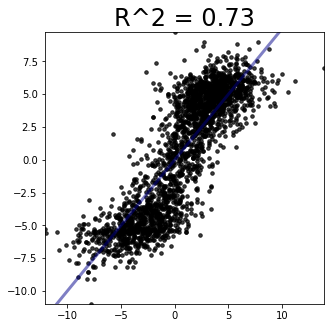

In [17]:
prox_count = apadb_gen[0][1][0][:, 0]
total_count = apadb_gen[0][1][1][:, 0]

iso_true = prox_count / total_count
logodds_true = np.log(iso_true / (1.0 - iso_true))

logodds_pred = np.ravel(np.log(iso_pred / (1.0 - iso_pred)))

r_val, _ = pearsonr(logodds_pred, logodds_true)

print("APADB log isoform prediction R^2 (Cross-Val) = " + str(r_val * r_val))
print("Accuracy = " + str(accuracy))

f = plt.figure(figsize=(5, 5))

plt.scatter(logodds_pred, logodds_true, s = np.pi * (2 * np.ones(1))**2, alpha=0.75, color='black')
min_x = max(np.min(logodds_pred), np.min(logodds_true))
max_x = min(np.max(logodds_pred), np.max(logodds_true))
min_y = max(np.min(logodds_pred), np.min(logodds_true))
max_y = min(np.max(logodds_pred), np.max(logodds_true))
plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

plt.axis([np.min(logodds_pred), np.max(logodds_pred), np.min(logodds_true), np.max(logodds_true)])
plt.title('R^2 = ' + str(round(rsquare, 2)), fontsize=24)
plt.show()
plt.close()